In [1]:
# I have already openCV instlalled. The official albumentations library advices to install it in that way
# !pip install -U albumentations --no-binary qudida,albumentations

In [4]:
%load_ext autoreload
%autoreload 2

from functools import partial
from pathlib import Path

# import albumentations
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf

from pitch_geo import data
from pitch_geo.data import KeyPointsDataset
from pitch_geo.data import read_image_and_keypoints
import vis_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# On single image

In [5]:
df = pd.read_csv('recruitment_task_pitch_geom/df_keypoints.csv')

df = df[df['dataset'] == 'train']

key = df.query('kid == 38 and vis != 0')['image_path'].item()
idx1 = df.query(f'kid == 39 and image_path == "{key}"').index
idx2 = df.query(f'kid == 38 and image_path == "{key}"').index
df.loc[idx1, 'x'] = df.loc[idx2, 'x'].item()
df.loc[idx1, 'y'] = df.loc[idx2, 'y'].item()
df.loc[idx1, 'vis'] = df.loc[idx2, 'vis'].item()

df = df[df['kid'] != 38]
df['kid'].nunique()

38

In [6]:
sample_img_path = 'images/train/c814ce8e31e077df861c2848fe14fb.jpg'
image = cv2.imread(f'recruitment_task_pitch_geom/{sample_img_path}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

keypoints = df[df['image_path'] == sample_img_path][['x', 'y']].values

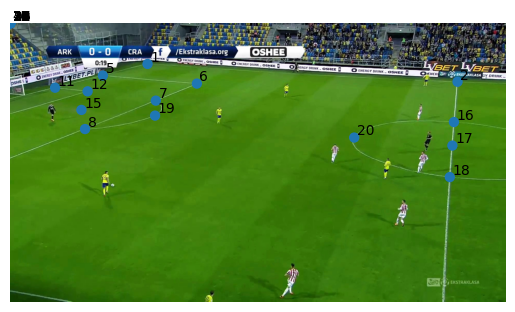

In [7]:
vis_utils.show_image_with_annotations(img=image, keypoints=keypoints, dot_radius= 20, normalized=False)

In [8]:
# transform = albumentations.Compose(
#     [
#         albumentations.RandomCrop(width=450, height=450), 
#         albumentations.HorizontalFlip(p=0.5), 
#         albumentations.RandomBrightnessContrast(p=0.2),
#         albumentations.RandomGamma(p=0.2), 
#         albumentations.RGBShift(p=0.2), 
#         albumentations.VerticalFlip(p=0.5)
#     ],
#     keypoint_params=albumentations.KeypointParams(format='xy', remove_invisible=False)
# )

In [9]:
# transformed = transform(image=image, keypoints=keypoints)

In [104]:
# def set_unvisible_keypoints(keypoints, width, height):
#     """ If a keypoint should be invisible, meaning it is outside of the image, set its coordinates to (0, 0). """
#     def is_outside(x, y):
#         return x <= 0 or x > width or y <= 0 or y > height
#     return list(map(lambda kp: (0, 0) if is_outside(*kp) else kp, keypoints))

In [13]:
# transformed_image = transformed['image']
# transformed_keypoints = transformed['keypoints']
# transformed_keypoints = set_unvisible_keypoints(transformed_keypoints, transformed_image.shape[1], transformed_image.shape[0])
# transformed_keypoints = np.array(transformed_keypoints)

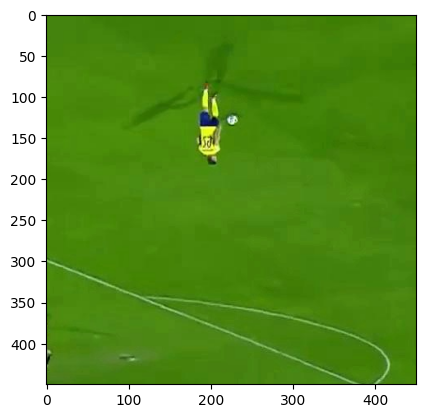

In [14]:
# plt.imshow(transformed_image)

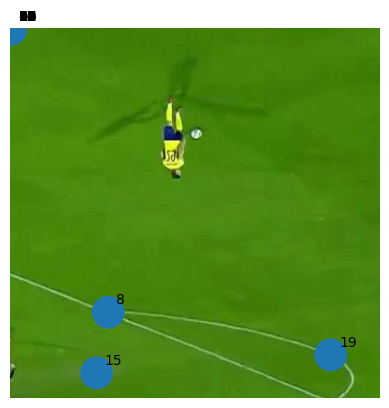

In [15]:
# vis_utils.show_image_with_annotations(img=transformed_image, keypoints=transformed_keypoints, dot_radius= 20, normalized=False)

In [22]:
# from typing import List

In [23]:
# def show_augmentation(augs: List, image=image, keypoints=keypoints):
#     transform = albumentations.Compose(
#         augs,
#         keypoint_params=albumentations.KeypointParams(format='xy', remove_invisible=False)
#     )
#     transformed = transform(image=image, keypoints=keypoints)

#     transformed_image = transformed['image']
#     transformed_keypoints = transformed['keypoints']
#     transformed_keypoints = set_unvisible_keypoints(transformed_keypoints, transformed_image.shape[1], transformed_image.shape[0])
#     transformed_keypoints = np.array(transformed_keypoints)
#     vis_utils.show_image_with_annotations(img=transformed_image, keypoints=transformed_keypoints, dot_radius= 20, normalized=False)

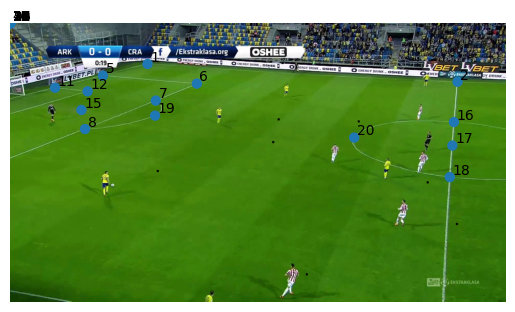

In [24]:
# show_augmentation([albumentations.augmentations.dropout.CoarseDropout()])

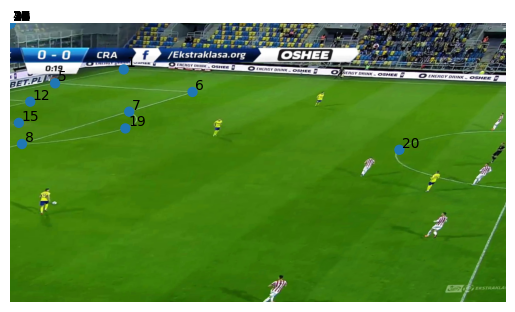

In [56]:
# show_augmentation([albumentations.augmentations.geometric.transforms.Perspective(scale=(0.099, 0.1), p=1.0)])

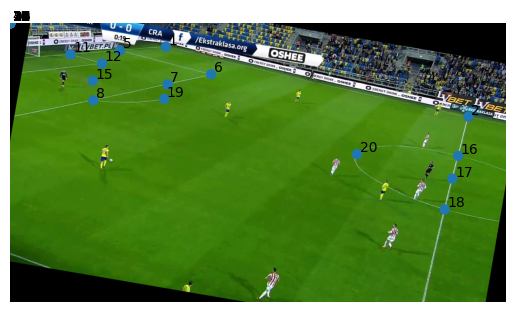

In [71]:
# show_augmentation([albumentations.augmentations.geometric.rotate.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0)])

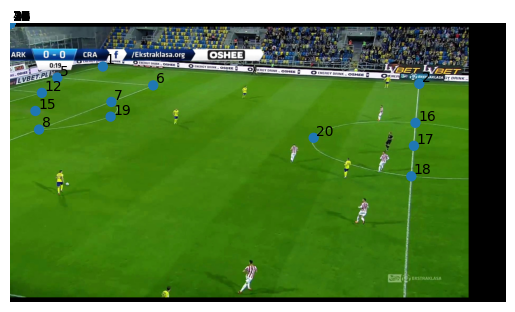

In [118]:
# affine = albumentations.augmentations.geometric.transforms.Affine(
#     scale=(0.9, 1.1), 
#     translate_percent=(-0.2, 0.2),
#     rotate=(-10, 10),
#     shear=None,
#     interpolation=1, 
#     mask_interpolation=0,
#     cval=0, 
#     cval_mask=0,
#     mode=0, 
#     fit_output=False,
#     keep_ratio=False, 
#     p=1.0
# )

# show_augmentation([affine])

# On tensorflow dataset

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 500
NUM_KEYPOINTS = 38 * 2  # 38 pairs each having x and y coordinates
DATA_FOLDER = Path('recruitment_task_pitch_geom')

AUTOTUNE = tf.data.AUTOTUNE

In [7]:
def load_image(
    path, image_size, num_channels, interpolation, crop_to_aspect_ratio=False
):
    """Load an image from a path and resize it. Taken from https://github.com/keras-team/keras/blob/v2.10.0/keras/utils/image_dataset.py#L30. """
    img = tf.io.read_file(path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    if crop_to_aspect_ratio:
        img = image_utils.smart_resize(
            img, image_size, interpolation=interpolation
        )
    else:
        img = tf.image.resize(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img


annotations_dict = data.df_to_dict2(df)

def get_annotations(image_path):
    # image_path is supposed to be bytes object
    all_annotatios = annotations_dict[image_path.numpy().decode('utf-8')]
    
    # For tranining, we are only interested in keypoints coordinates:
    return all_annotatios['keypoints']

In [8]:
images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

# train_df = df[df['image_path'].isin(train_paths)]
# val_df = df[~df['image_path'].isin(train_paths)]

train_absolute_paths = [str(DATA_FOLDER / p) for p in  train_paths]
train_paths = tf.data.Dataset.from_tensor_slices(train_paths)
train_files = tf.data.Dataset.from_tensor_slices(train_absolute_paths)

train_images = train_files.map(
    partial(
        load_image, 
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    )
)
# train_images = train_images.map(lambda x: x/255).cache()

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = train_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]))
# train_labels = train_labels.map(lambda x: tf.divide(x, IMG_SIZE))

# train_ds = tf.data.Dataset.zip((train_images, train_labels))

# train_ds = train_ds.shuffle(4000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

2022-11-19 22:57:16.728365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 22:57:16.744035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 22:57:16.744309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 22:57:16.745115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [157]:
# img = next(iter(train_images))

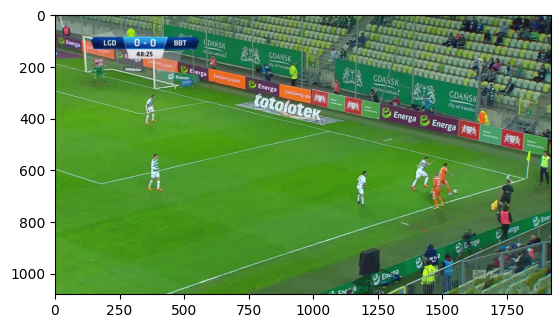

In [158]:
# plt.imshow(img.numpy())
# plt.show()

In [159]:
# next(iter(train_labels))

(<tf.Tensor: shape=(38, 2), dtype=float16, numpy=
 array([[   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [1813.,  635.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [ 176.,  655.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [ 330.,  385.],
        [ 588.,  337.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]], dtype=float16)>,)

In [383]:
# affine = albumentations.augmentations.Affine(
#     scale=None, 
#     translate_percent=0.4,
#     rotate=None,
#     shear=None, 
#     always_apply=True
# )


# transforms = albumentations.Compose([affine], keypoint_params=albumentations.KeypointParams(format='xy', remove_invisible=False))

In [384]:
# def aug_fn(image, keypoints, img_size):
#     print(f'In aug_fn')
#     aug_data = transform(image=image, keypoints=keypoints)
#     print('After transforming')
#     aug_img = aug_data["image"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     aug_kps = np.array(aug_data["keypoints"])
#     return aug_img, aug_kps

In [387]:
# def process_data(image, keypoints, img_size):
#     aug_img, aug_kps = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float16])
#     return aug_img, aug_kps


# ds_alb1 = tf.data.Dataset.zip((train_images, train_labels))
# ds_alb2 = ds_alb1.map(partial(process_data, img_size=IMG_SIZE))
# batch = next(iter(ds_alb2))

In aug_fn


2022-11-19 19:08:20.382063: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py", line 220, in py_function_wrapper
    ret = self._func(*nested_args)

  File "/tmp/ipykernel_20/9262

InvalidArgumentError: ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py", line 220, in py_function_wrapper
    ret = self._func(*nested_args)

  File "/tmp/ipykernel_20/926201527.py", line 2, in process_data
    aug_img, aug_kps = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float16])

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/tmp/ipykernel_20/2818632565.py", line 3, in aug_fn
    aug_data = transform(image=image, keypoints=keypoints)

  File "/home/tensorflow-user/.local/lib/python3.8/site-packages/albumentations/core/composition.py", line 205, in __call__
    data = t(**data)

  File "/home/tensorflow-user/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 118, in __call__
    return self.apply_with_params(params, **kwargs)

  File "/home/tensorflow-user/.local/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 131, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))

  File "/home/tensorflow-user/.local/lib/python3.8/site-packages/albumentations/augmentations/dropout/coarse_dropout.py", line 174, in apply_to_keypoints
    if not self._keypoint_in_hole(kp, hole):

  File "/home/tensorflow-user/.local/lib/python3.8/site-packages/albumentations/augmentations/dropout/coarse_dropout.py", line 165, in _keypoint_in_hole
    return x1 <= x < x2 and y1 <= y < y2

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

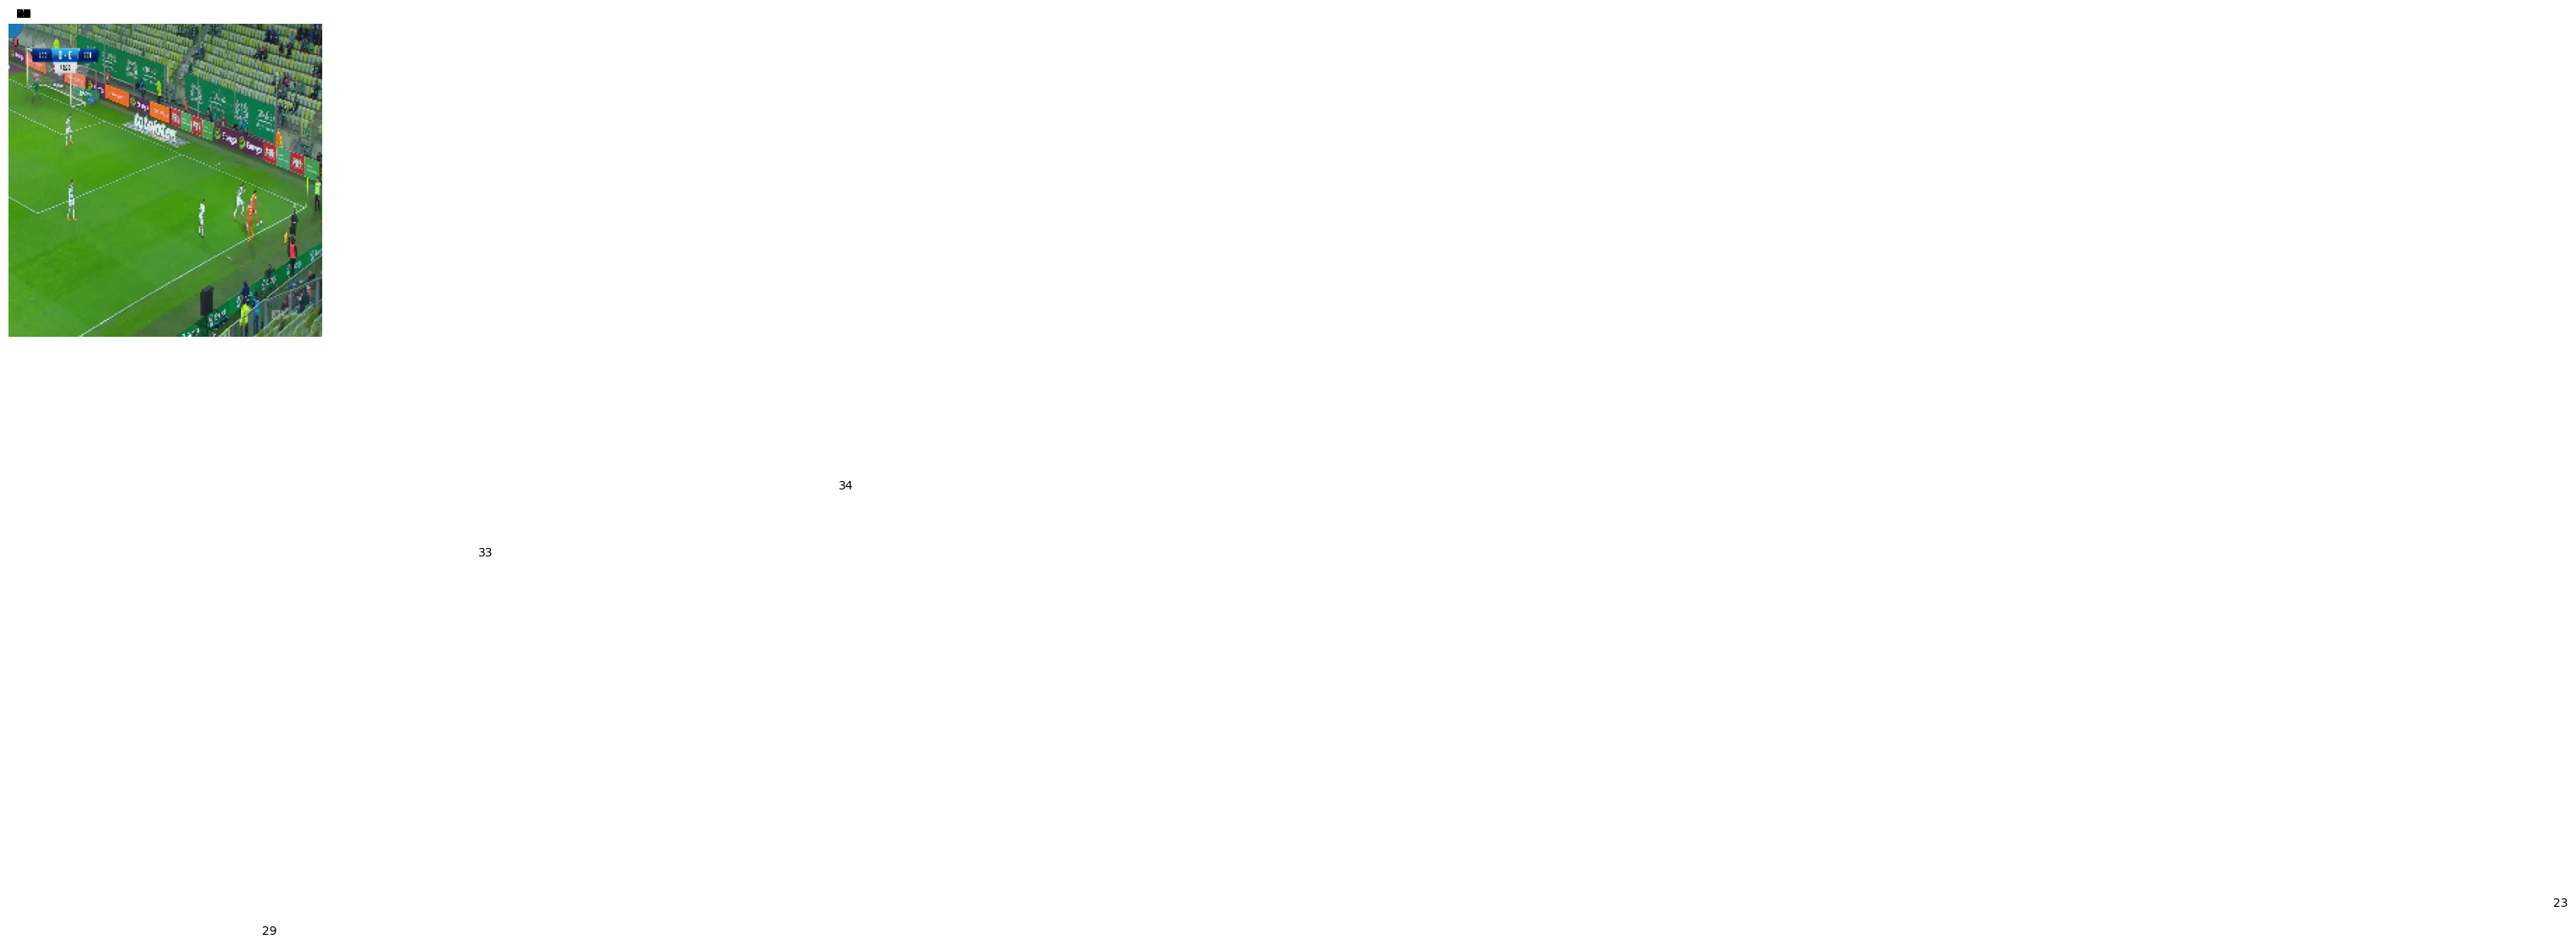

In [386]:
# vis_utils.show_image_with_annotations(batch[0].numpy(), batch[1].numpy(), normalized=False, dot_radius=10)

# My custom augmentations

In [9]:
tf.data.experimental.enable_debug_mode()

In [258]:
# sample_img_path

'images/train/c814ce8e31e077df861c2848fe14fb.jpg'

In [11]:
def random_translate(image, keypoints, limit=0.5):
    x_percent, y_percent = np.random.uniform(low=-limit, high=limit, size=2)
    return translate(image, keypoints, x_percent, y_percent)

def translate(image, keypoints, x_percent, y_percent):
      
    image_h, image_w = image.shape[:2]
    
    x = round(x_percent * image_w)
    y = round(y_percent * image_h)
    
    T = np.float32([[1, 0, x], [0, 1, y]])
    img_translation = cv2.warpAffine(image, T, (image_w, image_h))
        
    mask = keypoints.sum(axis=-1) != 0
    
    v_percent = np.array([x_percent, y_percent]) 
    keypoints[mask] += v_percent
    
    # Check if after translation some kyepoint are out of the frame
    mask = np.logical_or((keypoints > np.ones(2)).any(axis=1), (keypoints < np.zeros(2)).any(axis=1))
    keypoints[mask] = np.array([0., 0.])
    return img_translation, keypoints

In [12]:
train_images = train_files.map(
    partial(
        load_image, 
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'        
    )
)
train_images = train_images.map(lambda x: x/255)

# Wrapping this inside tf.py_function s necessary. Otherwise TF throws AttributeError: 'Tensor' object has no attribute 'numpy'
train_labels = train_paths.map(lambda file_name: tf.py_function(get_annotations, [file_name], [tf.float16]))
train_labels = train_labels.map(lambda x: tf.divide(x, tf.constant([1920., 1080.], dtype=tf.float16)))

train_ds_ = tf.data.Dataset.zip((train_images, train_labels))
# batch = next(iter(train_ds))
# train_ds = train_ds.shuffle(4000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = train_ds_.map(
    lambda image, keypoints: tf.numpy_function(func=random_translate, inp=[image, keypoints, 0.5], Tout=[tf.float32, tf.float16]),
    num_parallel_calls=AUTOTUNE
)
train_ds = train_ds.batch(2).prefetch(buffer_size=AUTOTUNE)
batch = next(iter(train_ds))
# vis_utils.show_image_with_annotations(batch[0].numpy(), batch[1].numpy(), normalized=True, dot_radius=3)

In [17]:
train_ds = (
    train_ds_
    .shuffle(4000)
    .map(
        lambda image, keypoints: tf.numpy_function(func=random_translate, inp=[image, keypoints, 0.3], Tout=[tf.float32, tf.float16]),
        num_parallel_calls=AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
batch = next(iter(train_ds))

In [18]:
batch = next(iter(train_ds))

2022-11-19 23:02:49.209932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 561 of 4000
2022-11-19 23:02:59.209443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1107 of 4000
2022-11-19 23:03:09.217127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1661 of 4000
2022-11-19 23:03:19.217016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2202 of 4000
2022-11-19 23:03:29.202816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2751 of 4000
2022-11-19 23:03:38.152252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [16]:
for i, batch in enumerate(train_ds):
    print(f'{i + 1}/{len(train_ds)}', end='\r')
    continue

In [16]:
batch

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.2848038 , 0.5558826 , 0.15539204],
         [0.27965695, 0.5449584 , 0.14751376],
         [0.29012528, 0.5531856 , 0.17706479],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.27920175, 0.5693978 , 0.13410369],
         [0.28078672, 0.5618299 , 0.13069218],
         [0.28167766, 0.5522659 , 0.13573924],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.26309574, 0.56096965, 0.13482921],
         [0.267602  , 0.5629555 , 0.13641477],
         [0.2674369 , 0.55364126, 0.14208697],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.        , 0.        

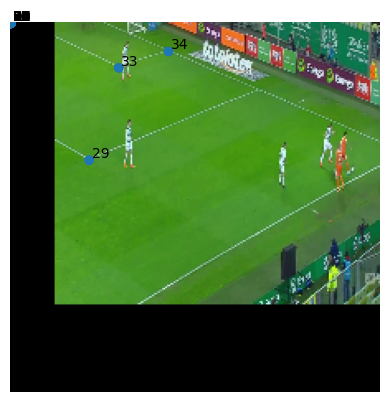

In [14]:
batch = next(iter(train_ds))
vis_utils.show_image_with_annotations(batch[0].numpy(), batch[1].numpy(), normalized=True, dot_radius=3)